# Simple convolutional neural network (CNN)

In [12]:
# Change the file directory to you own here:
### Load data
drive_path = 'C:/Users/vinde/OneDrive/Dokumenter/DTU/Deep Learning/DLproject_PredictingSecondaryProteinStructure/DLproject_PredictingSecondaryProteinStructure--main/'

## Loading packages

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from torch.autograd import Variable
import torch.nn as nn
import sklearn.model_selection as model_selection
import pickle

In [14]:
def getAccuracy(predictions,targets):
    targets = np.squeeze(targets.permute(0,2,1).argmax(dim=2).view(-1,targets.shape[0]*targets.shape[2]).data.numpy())
    pred = np.squeeze(softmax(predictions.permute(0,2,1),dim=2).argmax(dim=2).view(-1,predictions.shape[0]*predictions.shape[2]).data.numpy())
    correct = 0
    pred = pred[targets != 8]
    targets = targets[targets != 8]
    correct = (pred == targets).sum()
    return correct/np.size(targets)

## Loading data

In [15]:
traindata = pickle.load(open(drive_path+'train_reduced.pickle','rb'))

X = traindata[0][:,:,0:20]
y = traindata[1]
CASP12data = pickle.load(open(drive_path+'Casp12Data.pickle','rb'))
X_casp = CASP12data[0][:,:,0:20]
y_casp = CASP12data[0][:,:,57:65]
TS115data = pickle.load(open(drive_path+'TS115.pickle','rb'))
X_TS115 = TS115data[0][:,:,0:20]
y_TS115 = TS115data[0][:,:,57:65]
CB513data = pickle.load(open(drive_path+'CB513.pickle','rb'))
X_CB513 = CB513data[0][:,:,0:20]
y_CB513 = CB513data[0][:,:,57:65]

In [16]:
print(y.shape)
print(X.shape)

(1500, 1632, 8)
(1500, 1632, 20)


## Adding the "artificial" class created by the extrapolation of the sequences

In [17]:
if y.shape[2] == 8:
    EPzeros = np.expand_dims(np.zeros((y.shape[1])),1)
    EPzeros_casp = np.expand_dims(np.zeros((y_casp.shape[1])),1)
    EPzeros_TS115 = np.expand_dims(np.zeros((y_TS115.shape[1])),1)
    EPzeros_CB513 = np.expand_dims(np.zeros((y_CB513.shape[1])),1)
    y_red = np.asarray([np.hstack((y[i],EPzeros)) for i in range(y.shape[0])])
    y_casp = np.asarray([np.hstack((y_casp[i],EPzeros_casp)) for i in range(y_casp.shape[0])])
    y_TS115 = np.asarray([np.hstack((y_TS115[i],EPzeros_TS115)) for i in range(y_TS115.shape[0])])
    y_CB513 = np.asarray([np.hstack((y_CB513[i],EPzeros_CB513)) for i in range(y_CB513.shape[0])])
    for i in range(y.shape[0]):
        for j in range(y[i].shape[0]):
            if np.all(y[i][j,:] == 0):
                y[i][j,:][-1] = 1
    for i in range(y_casp.shape[0]):
        for j in range(y_casp[i].shape[0]):
            if np.all(y_casp[i][j,:] == 0):
                y_casp[i][j,:][-1] = 1
    for i in range(y_TS115.shape[0]):
        for j in range(y_TS115[i].shape[0]):
            if np.all(y_TS115[i][j,:] == 0):
                y_TS115[i][j,:][-1] = 1
    for i in range(y_CB513.shape[0]):
        for j in range(y_CB513[i].shape[0]):
            if np.all(y_CB513[i][j,:] == 0):
                y_CB513[i][j,:][-1] = 1

In [18]:
X = torch.tensor(X, dtype = torch.float)
y = torch.tensor(y, dtype = torch.float).permute(0,2,1)
X_casp = torch.tensor(X_casp,dtype = torch.float)
y_casp = torch.tensor(y_casp,dtype=torch.float).permute(0,2,1)
X_TS115 = torch.tensor(X_TS115,dtype=torch.float)
y_TS115 = torch.tensor(y_TS115,dtype=torch.float).permute(0,2,1)
X_CB513 = torch.tensor(X_CB513,dtype=torch.float)
y_CB513 = torch.tensor(y_CB513,dtype=torch.float).permute(0,2,1)

class MyDataset(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.targets = y

    def __getitem__(self, index):
      x = self.data[index]
      y = self.targets[index]
      return x, y
    
    def __len__(self):
      return len(self.data)

batch_size = 65
TrainLoader = DataLoader(MyDataset(X,y),batch_size=batch_size)
CASPLoader = DataLoader(MyDataset(X_casp,y_casp),batch_size=3)
TS115Loader = DataLoader(MyDataset(X_TS115,y_TS115),batch_size=batch_size)
CB513Loader = DataLoader(MyDataset(X_CB513,y_CB513),batch_size=batch_size)

## Defining the model architecture

In [19]:
channels = 20
kernel_size_conv1 = 15
padding_conv1 = 7
stride_conv1 = 1
kernel_size_conv2 = 9
padding_conv2 = 4
stride_conv2 = 1
kernel_size_conv3 = 5
padding_conv3 = 2
stride_conv3 = 1

class Net(nn.Module):
    def __init__(self):
        ''''''
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=channels,out_channels=25,kernel_size=kernel_size_conv1 , stride=stride_conv1, padding=padding_conv1),
            nn.ReLU(),
            nn.BatchNorm1d(25),
            nn.Dropout(p=0.5))

        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=25, out_channels=35, kernel_size=kernel_size_conv2, stride=stride_conv2, padding=padding_conv2),
            nn.ReLU(),
            nn.BatchNorm1d(35),
            nn.Dropout(p=0.5))

        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=35,out_channels=40, kernel_size=kernel_size_conv3, stride=stride_conv3, padding=padding_conv3),
            nn.ReLU(),
            nn.BatchNorm1d(40),
            nn.Dropout(p=0.5))

        self.fc1_encode1 = nn.Sequential(
            nn.Conv1d(in_channels=40,out_channels=9,kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm1d(9)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1_encode1(x)
        return x
net = Net()

In [20]:
# Defining criterion and optimizer
import torch.optim as optim

def criterion(input, target):
    labels = torch.argmax(target,2)
    return nn.CrossEntropyLoss()(input, labels)

# Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001,betas=(0.85,0.95),weight_decay=1e-6)

## Training loop

In [21]:
num_epoch = 100
train_loss = []
train_accuracy = []
casp_loss = []
casp_accuracy = []
TS115_loss = []
TS115_accuracy = []
CB513_loss = []
CB513_accuracy = []

for epoch in range(num_epoch):  # loop over the dataset multiple times
    print('Epoch ',epoch+1,' of ',num_epoch)
    running_loss = 0.0
    running_acc = 0.0
    net.train()
    print('Training net')
    for data in TrainLoader:
        # get the inputs
        inputs, labels = data
        # wrap them in Variable
        inputs, labels = Variable(inputs.permute(0,2,1)), Variable(labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        running_acc += getAccuracy(outputs,labels)
        loss = criterion(outputs,labels.permute(0,2,1))
        loss.backward()
        running_loss += loss.data.numpy()
        optimizer.step()
    train_loss.append(running_loss/len(TrainLoader))
    train_accuracy.append(running_acc/len(TrainLoader))
    net.eval()
    with torch.no_grad():
        running_loss = 0.0
        running_acc = 0.0
        print('Testing on CASP')
        for data in CASPLoader:
            inputs, labels = data
            outputs = net(Variable(inputs.permute(0,2,1)))
            loss = criterion(outputs,labels.permute(0,2,1))
            running_acc += getAccuracy(outputs,labels)
            running_loss += loss.data.numpy()
        casp_loss.append(running_loss/len(CASPLoader))
        casp_accuracy.append(running_acc/len(CASPLoader))
        running_loss = 0.0
        running_acc = 0.0
        print('Testing on TS115')
        for data in TS115Loader:
            inputs, labels = data
            outputs = net(Variable(inputs.permute(0,2,1)))
            loss = criterion(outputs,labels.permute(0,2,1))
            running_acc += getAccuracy(outputs,labels)
            running_loss += loss.data.numpy()
        TS115_loss.append(running_loss/len(TS115Loader))
        TS115_accuracy.append(running_acc/len(TS115Loader))
        running_loss = 0.0
        running_acc = 0.0
        print('Testing on CB513')
        for data in CB513Loader:
            inputs, labels = data
            outputs = net(Variable(inputs.permute(0,2,1)))
            loss = criterion(outputs,labels.permute(0,2,1))
            running_acc += getAccuracy(outputs,labels)
            running_loss += loss.data.numpy()
        CB513_loss.append(running_loss/len(CB513Loader))
        CB513_accuracy.append(running_acc/len(CB513Loader))
print('Finished Training')

Epoch  1  of  3
Training net
Testing on CASP
Testing on TS115
Testing on CB513
Epoch  2  of  3
Training net
Testing on CASP
Testing on TS115
Testing on CB513
Epoch  3  of  3
Training net
Testing on CASP
Testing on TS115
Testing on CB513
Finished Training


## Creating plots

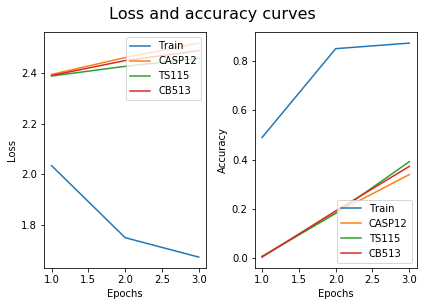

In [22]:
scale = list(range(1,num_epoch+1))
fig, axs = plt.subplots(1, 2, constrained_layout=False)
axs[0].plot(scale, train_loss,label='Train')
axs[0].plot(scale, casp_loss,label='CASP12')
axs[0].plot(scale, TS115_loss,label='TS115')
axs[0].plot(scale, CB513_loss,label='CB513')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(loc='upper right')
axs[1].plot(scale, train_accuracy,label='Train')
axs[1].plot(scale, casp_accuracy,label='CASP12')
axs[1].plot(scale, TS115_accuracy,label='TS115')
axs[1].plot(scale, CB513_accuracy,label='CB513')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(loc='lower right')
fig.suptitle('Loss and accuracy curves', fontsize=16,y=1.05)
plt.tight_layout()
plt.show()